# Statistical Concept Illustration

In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random

#machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

#models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier

#export object
import joblib

# For 1) overfitting and 2) regularisation, we will use melborne housing price to illustrate

In [4]:
df = pd.read_csv("Melbourne_housing_FULL.csv")

## clean and preprocess data 

In [5]:
#trim dataset
df = df[['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Distance', "CouncilArea", 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea','Regionname', 'Propertycount']]

#missing value treatment
df[["Propertycount", "Distance", "Bedroom2", "Bathroom", "Car"]] = df[["Propertycount", "Distance", "Bedroom2", "Bathroom", "Car"]].fillna(0)
df["Landsize"] = df["Landsize"].fillna(df["Landsize"].mean())
df["BuildingArea"] = df["BuildingArea"].fillna(df["BuildingArea"].mean())
df.dropna(inplace=True)

#create dummy variables for categorical columns
cat_varibles = ['Type', 'Suburb', "Method","SellerG", "CouncilArea", "Regionname"]

for col in cat_varibles:
    dummy = pd.get_dummies(df[col])
    df.drop(col,axis="columns", inplace=True)
    df = pd.concat([df,dummy], axis="columns")

## train test split 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("Price", axis="columns"), df["Price"], 
                                                    test_size = 0.2, random_state = 42)

# 1) Overfitting

overfitting a model refers to when the model was fitting too well to the training data and resulted to poor prediction on the test data. This is also refer to as that the model has high variance. 

Some reasons are as follows: 
1. Data is not clean 
2. High variance
3. size of training data is not enough
4. model is too complex

Let's see the example on the melborne training dataset when you fit a regular linear regression model


In [7]:
#initialise
regress = LinearRegression() 

#fitting (training)
regress.fit(X_train, y_train)

# predicting (testing)
y_pred = regress.predict(X_test)

#creating a coefficent table
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns), "Coefs", regress.coef_.transpose())
coef_table = coef_table[[0,"Coefs"]]
coef_table.columns = ["Variables", "Coefficient"]

### Observation 1: the predicted result on the training data has a R2 score of 0.62. It is moderately accurate

In [8]:
regress.score(X_train, y_train)

0.6777287226519022

### Obervation 2 The predicted result on test data produce a negative R2 score. Meaning it fits worse than a horizontal line. 

In [9]:
regress.score(X_test, y_test)

-8783056700.649033

### Conclusion: The huge disparity in performance in training and test data performance indicated that the model is overfitted

# 2) Regularization
To avoid overfitting, a function is added to the MSE to penalise large theta values that is "overdominating" the model

In [10]:
lasso_regress = Lasso(alpha=42, max_iter=100, tol=0.1)

#fitting (training)
lasso_regress.fit(X_train, y_train)

# predicting (testing)
y_pred = lasso_regress.predict(X_test)

#creating a coefficent table
coef_table_lasso = pd.DataFrame(list(X_train.columns)).copy()
coef_table_lasso.insert(len(coef_table_lasso.columns), "Coefs", lasso_regress.coef_.transpose())
coef_table_lasso = coef_table_lasso[[0,"Coefs"]]
coef_table_lasso.columns = ["Variables", "Coefficient"]

C:\Users\FAN_HUI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1498753440402655.2, tolerance: 896116484967959.0
  model = cd_fast.enet_coordinate_descent(


### Observation 1:  After regularisation of the Thetas, the testing and training result are closer

In [11]:
lasso_regress.score(X_train, y_train)

0.6739717849145501

In [12]:
lasso_regress.score(X_test, y_test)

0.6844577002785179

### Observation 2:  Graphs below shows the coefficient values before (top) and after (bottom) regularisation. As expected, the range of coefficients is reduced, and more variables are making meaningful contribution to the prediction

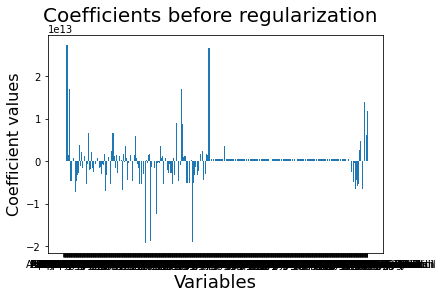

In [13]:
fig = plt.figure()
plt.bar(coef_table["Variables"], coef_table["Coefficient"])

plt.suptitle('Coefficients before regularization', fontsize=20)
plt.xlabel('Variables', fontsize=18)
plt.ylabel('Coefficient values', fontsize=16)

plt.show()

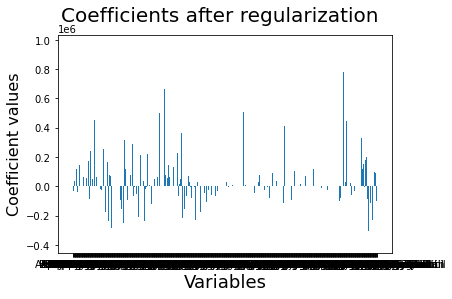

In [14]:
fig = plt.figure()
plt.bar(coef_table_lasso["Variables"], coef_table_lasso["Coefficient"])

plt.suptitle('Coefficients after regularization', fontsize=20)
plt.xlabel('Variables', fontsize=18)
plt.ylabel('Coefficient values', fontsize=16)
plt.show()

# 3) Ensemble
* This is techniques that aim at improving the accuracy of results in models by combining multiple models instead of using a single model
* We will use the loan default dataset as an example
* We will train 71 trees, each one trained with 70% of randomly selected columns and record the score of each tree on the test data
* Lastly, for ensemble method, we will let each of the 71 tree vote on the prediction and pass the prediction as the most voted result, and record the accuracy using the ensemble method 

In [21]:
df = pd.read_csv("cleaned_borrower_profile.csv")

In [22]:
#quick preprocessing to get it ready for training - testing
# balancing the data. Make the 2 class 50:50
default_class = {}

for y in set(list(df["status"])):
    default_class[y] = df[df["status"] == y]
    
expanded_defaulter = default_class[1].sample(n=len(default_class[0]),replace=True)

df = pd.concat([default_class[0], expanded_defaulter],axis="index")
df["status"].value_counts(normalize=True)

#one hot encoding
cat_varibles = ['gender', 'maritalstatus', "jobpos"]

for col in cat_varibles:
    dummy = pd.get_dummies(df[col])
    df.drop(col,axis="columns", inplace=True)
    df = pd.concat([df,dummy], axis="columns")
    
# train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop("status", axis="columns"), df["status"], 
                                                    test_size = 0.2, random_state = 42)

In [63]:
#pre-loop setting
column_portion = round(len(list(X_train.columns)) * 0.7)
compiled_y_test = pd.DataFrame(y_test.copy())
auc_tree_score = []

#train each tree and record predictive performance
for i in range(1,72):
    #random sample columns for training
    column_current_tree = random.sample(list(X_train.columns), column_portion)
    X_train_subset = X_train.copy()
    X_train_subset = X_train_subset[column_current_tree]
    X_test_subset = X_test.copy()
    X_test_subset = X_test_subset[column_current_tree]

    #initialise tree for training
    Tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
    Tree.fit(X_train_subset, y_train)
    
    #append prediction for each row
    y_pred = pd.Series(Tree.predict(X_test_subset), name=("Tree" + str(i)))
    compiled_y_test = pd.concat([compiled_y_test.reset_index(drop=True), y_pred], axis = "columns")
    
    #append AUC performance for each tree
    auc_tree_score.append(roc_auc_score(y_test, y_pred))

### observation 1: with 71 trees, you can observe a distribution of AUC score. Mostly within the range of 0.80 to 0.90, with best peroforming tree at AUC of 0.896

best performing tree has AUC of: 0.8961398570135527


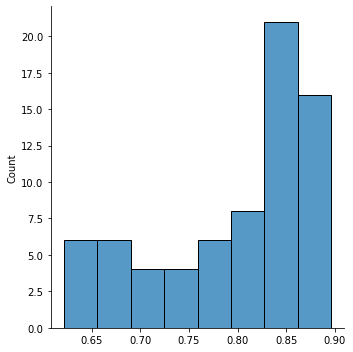

In [71]:
sns.displot(auc_tree_score);
print("best performing tree has AUC of: " + str(max(auc_tree_score)))

### Obseration 2: For ensemble method, we allow each tree a voting right. Allow the prediction for each dataset to be the most-voted prediction. As expected, the AUC for ensembled method performed better than all the indvidual trees at 89.9% AUC

In [78]:
ensembled_pred = compiled_y_test.drop('status',axis="columns")
compiled_y_test["ensembled prediction"] = ensembled_pred.mode(axis=1)

In [79]:
accuracy_score(compiled_y_test["ensembled prediction"] , y_pred)

0.8994268234735091